# Sequential Conv + Pool +Flatten + Dense

## 00. Imports

In [1]:
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix

In [2]:
import sys
sys.path.append("../")

In [3]:
from src.activation.relu import ReluLayer
from src.layers.pooling import MaxPoolLayer
from src.activation.softmax import SoftmaxLayer
from src.layers.dense import DenseLayer
from src.layers.flatten import FlattenLayer
from src.layers.convolutional import ConvLayer2D
from src.model.sequential import SequentialModel
from src.utils.core import convert_categorical2one_hot, convert_prob2categorical
from src.utils.metrics import softmax_accuracy
from src.optimizers.gradient_descent import GradientDescent
from src.optimizers.rms_prop import RMSProp
from src.optimizers.adam import Adam

## 01. Settings

In [4]:
# number of samples in the train data set
N_TRAIN_SAMPLES = 1000
# number of samples in the test data set
N_TEST_SAMPLES = 1000
# number of samples in the validation data set
N_VALID_SAMPLES = 1000
# number of classes
N_CLASSES = 10
# image size
IMAGE_SIZE = 28

## 02. Build data set

In [5]:
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
print("trainX shape:", trainX.shape)
print("trainY shape:", trainY.shape)
print("testX shape:", testX.shape)
print("testY shape:", testY.shape)

trainX shape: (60000, 28, 28)
trainY shape: (60000,)
testX shape: (10000, 28, 28)
testY shape: (10000,)


In [6]:
X_train = trainX[:N_TRAIN_SAMPLES, :, :]
y_train = trainY[:N_TRAIN_SAMPLES]

X_test = trainX[N_TRAIN_SAMPLES:N_TRAIN_SAMPLES+N_TEST_SAMPLES, :, :]
y_test = trainY[N_TRAIN_SAMPLES:N_TRAIN_SAMPLES+N_TEST_SAMPLES]

X_valid = testX[:N_VALID_SAMPLES, :, :]
y_valid = testY[:N_VALID_SAMPLES]

**NOTE:** We need to change the data format to the shape supported by my implementation.

In [7]:
X_train = X_train / 255
X_train = np.expand_dims(X_train, axis=3)
y_train = convert_categorical2one_hot(y_train)
X_test = X_test / 255
X_test = np.expand_dims(X_test, axis=3)
y_test = convert_categorical2one_hot(y_test)
X_valid = X_valid / 255
X_valid = np.expand_dims(X_valid, axis=3)
y_valid = convert_categorical2one_hot(y_valid)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)

X_train shape: (1000, 28, 28, 1)
y_train shape: (1000, 10)
X_test shape: (1000, 28, 28, 1)
y_test shape: (1000, 10)
X_valid shape: (1000, 28, 28, 1)
y_valid shape: (1000, 10)


## 03. Build model

In [8]:
layers = [
    # input (N, 28, 28, 1) out (N, 26, 26, 16)
    ConvLayer2D.initialize(filters=16, kernel_shape=(3, 3, 1), stride=1),
    # input (N, 26, 26, 16) out (N, 26, 26, 16)
    ReluLayer(),
    # input (N, 26, 26, 16) out (N, 13, 13, 16)
    MaxPoolLayer(pool_size=(2, 2), stride=2),
    # input (N, 13, 13, 16) out (N, 9, 9, 32)
    ConvLayer2D.initialize(filters=32, kernel_shape=(5, 5, 16), stride=1),
    # input (N, 9, 9, 32) out (N, 9, 9, 32)
    ReluLayer(),
     # input (N, 9, 9, 32) out (N, 3, 3, 32)
    MaxPoolLayer(pool_size=(3, 3), stride=3),
    # input (N, 3, 3, 32) out (N, 288)
    FlattenLayer(),
    DenseLayer.initialize(units_prev=288, units_curr=256),
    ReluLayer(),
    DenseLayer.initialize(units_prev=256, units_curr=256),
    ReluLayer(),
    DenseLayer.initialize(units_prev=256, units_curr=128),
    ReluLayer(),
    DenseLayer.initialize(units_prev=128, units_curr=64),
    ReluLayer(),
    DenseLayer.initialize(units_prev=64, units_curr=N_CLASSES),
    SoftmaxLayer()
]

optimizer = Adam(lr=0.003)

model = SequentialModel(
    layers=layers,
    optimizer=optimizer
)

## 04. Train

In [9]:
model.train(
    x_train=X_train, 
    y_train=y_train, 
    x_test=X_test, 
    y_test=y_test, 
    epochs=30,
    bs=128,
    verbose=True
)

Iter: 00001 - test loss: 1.96424 - test accuracy: 0.20800
Iter: 00002 - test loss: 1.44079 - test accuracy: 0.45500
Iter: 00003 - test loss: 1.14989 - test accuracy: 0.54400
Iter: 00004 - test loss: 0.91847 - test accuracy: 0.64600
Iter: 00005 - test loss: 0.81753 - test accuracy: 0.67200
Iter: 00006 - test loss: 0.76650 - test accuracy: 0.72100
Iter: 00007 - test loss: 0.71122 - test accuracy: 0.73900
Iter: 00008 - test loss: 0.70954 - test accuracy: 0.75200
Iter: 00009 - test loss: 0.78738 - test accuracy: 0.75000
Iter: 00010 - test loss: 0.86500 - test accuracy: 0.74000
Iter: 00011 - test loss: 0.69355 - test accuracy: 0.76700
Iter: 00012 - test loss: 0.75045 - test accuracy: 0.76600
Iter: 00013 - test loss: 0.85861 - test accuracy: 0.77600
Iter: 00014 - test loss: 0.84636 - test accuracy: 0.80300
Iter: 00015 - test loss: 0.98152 - test accuracy: 0.79000
Iter: 00016 - test loss: 0.95457 - test accuracy: 0.78400
Iter: 00017 - test loss: 0.92549 - test accuracy: 0.79100
Iter: 00018 - 

## 05. Predict and examine results

In [10]:
y_hat = model.predict(X_valid)
acc = softmax_accuracy(y_hat, y_valid)
print("acc: ", acc)

acc:  0.775


In [11]:
y_hat = convert_prob2categorical(y_hat)
y_valid = convert_prob2categorical(y_valid)

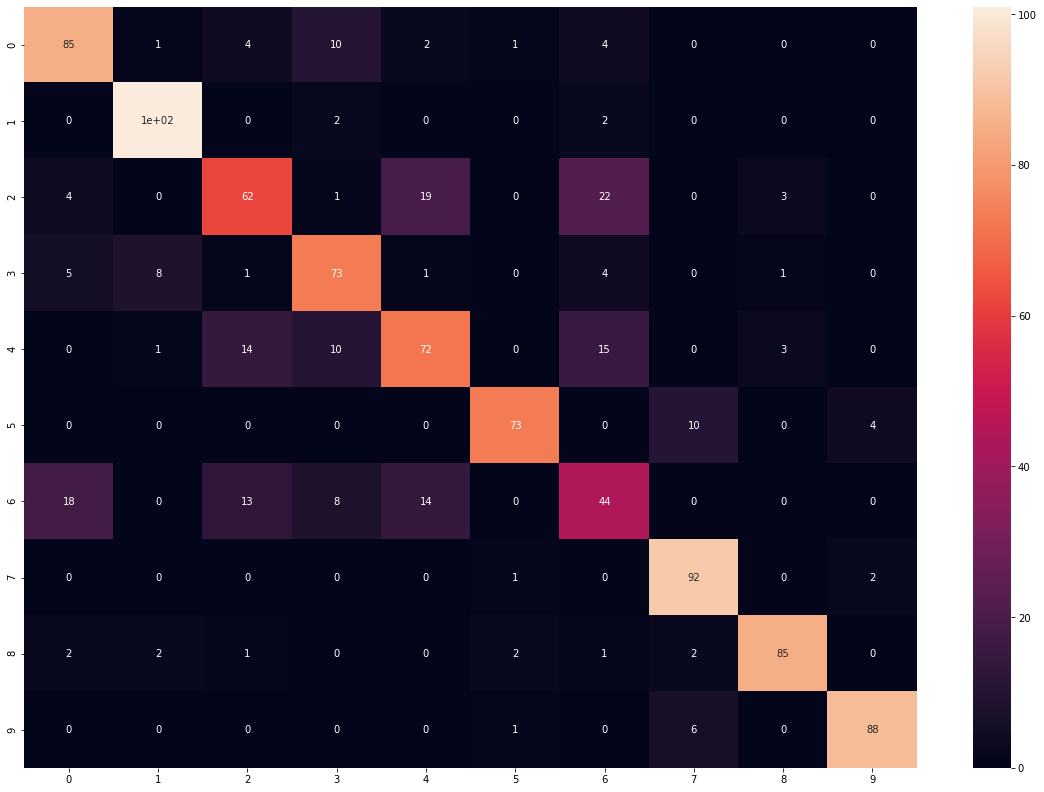

In [12]:
df_cm = pd.DataFrame(
    confusion_matrix(y_valid, y_hat), 
    range(10), 
    range(10)
)
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True)
plt.show()